# 18460 Project

In [1]:
from client import *
import matplotlib.pyplot as plt
import numpy as np
from problem import *
from server import *

First, we load the dataset and partition it

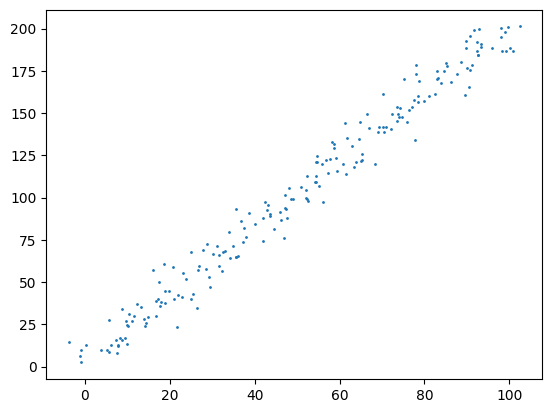

In [2]:
# TODO: load (and format) and partition dataset

# Example: Linear regression
x = np.linspace(0, 100, num=200)
y = 2*x + 3

points = np.stack((x, y), axis=-1)

dataset = points + 4*np.random.standard_normal(points.shape) # add noise to points

plt.scatter(dataset[:, 0], dataset[:, 1], s=1)

partitions = dataset.reshape((20, 10, 2)) # 20 clients with 10 points each

Then, we define our optimization problem

In [3]:
# TODO: define cost functions and optimization hyperparameters

hyper_parameters = {
    "penalty": 10,
    "x0": np.random.standard_normal((2, 1)) # one multiplicative term and one bias term
}

# simple linear regression cost (mean squarred error loss)
def cost(x, dataset, params):
    m = x[0]
    b = x[1]
    
    preimages = dataset[:, 0] # x-coordinate of points
    images = dataset[:, 1] # y-coordinate of points
    
    prediction = m*preimages + b
    
    return np.sum((prediction - images)**2) / len(dataset)

def cost_grad(x, dataset, params):
    m = x[0]
    b = x[1]
    
    preimages = dataset[:, 0] # x-coordinate of points
    images = dataset[:, 1] # y-coordinate of points
    
    prediction = m*preimages + b
    
    grad = np.array([
        np.sum(2*preimages*(prediction - images)),
        np.sum(2*(prediction - images))
    ]) / len(dataset)
    
    return grad[:, None] # make sure to return something with shape (2, 1)

def cost_hessian(x, dataset, params):
    m = x[0]
    b = x[1]
    
    preimages = dataset[:, 0] # x-coordinate of points
    images = dataset[:, 1] # y-coordinate of points

    hessian = np.array([
        [np.sum(2*(preimages**2)), np.sum(2*preimages)],
        [np.sum(2*preimages),           2*len(dataset)]
    ]) / len(dataset)
    
    return hessian

problem = OptimizationProblem(tol=1e-3, max_iter=40, loss=cost, loss_grad=cost_grad, 
                              loss_hessian=cost_hessian, hyper_parameters=hyper_parameters)

Solve iteratively using federated learning

In [4]:
# TODO: create server and initialize clients, before iteratively updating the consensus variables
server = Server(problem)
server.connect_clients(partitions) # add parameters and communicate datasets

k = 0
while k < problem.max_iter and server.delta > problem.tol:
    # perform new iteration
    server.run_iteration()
    
    consensus = server.consensus.flatten()
    
    print(f'''
    Iteration {k}: {consensus}
    Cost: {cost(consensus, dataset, problem.hyper_parameters)}
    
    ''')
    
    k = k + 1
    
if server.delta > problem.tol:
    raise Exception("Did not converge")


    Iteration 0: [1891.39468494   19.5060943 ]
    Cost: 12045314496.486025
    
    

    Iteration 1: [-71458557.72042078   -735011.99601694]
    Cost: 1.7230276238369563e+19
    
    

    Iteration 2: [2.69992389e+12 2.77709789e+10]
    Cost: 2.459726190256301e+28
    
    

    Iteration 3: [-1.02011421e+17 -1.04927291e+15]
    Cost: 3.5114081567684896e+37
    
    

    Iteration 4: [3.85430492e+21 3.96447548e+19]
    Cost: 5.012747879112111e+46
    
    

    Iteration 5: [-1.45627483e+26 -1.49790065e+24]
    Cost: 7.156001289997474e+55
    
    

    Iteration 6: [5.50225379e+30 5.65952893e+28]
    Cost: 1.0215625381006772e+65
    
    

    Iteration 7: [-2.07892055e+35 -2.13834393e+33]
    Cost: 1.458342413533949e+74
    
    

    Iteration 8: [7.85480063e+39 8.07932042e+37]
    Cost: 2.0818721476084775e+83
    
    

    Iteration 9: [-2.96778503e+44 -3.05261551e+42]
    Cost: 2.971998618956054e+92
    
    

    Iteration 10: [1.12132038e+49 1.15337194e+47]
    Cost: 4.24

C:\Users\antoi\AppData\Local\Temp\ipykernel_11548\1499211433.py:18: RuntimeWarning: overflow encountered in square
  return np.sum((prediction - images)**2) / len(dataset)


Exception: Did not converge